<a href="https://colab.research.google.com/github/sakshisinghal936/MNIST_/blob/main/MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Scope & goal

Input: 28×28 grayscale digit image

Output: predicted digit (0–9) + confidence

## Load Data

In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [2]:
!pip install -q kaggle

In [4]:
!kaggle competitions download -c digit-recognizer
!unzip digit-recognizer.zip

  0% 0.00/15.3M [00:00<?, ?B/s]
100% 15.3M/15.3M [00:00<00:00, 1.28GB/s]
Archive:  digit-recognizer.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [5]:
import pandas as pd

df_train = pd.read_csv("/content/train.csv")
df_test = pd.read_csv("/content/test.csv")

## EDA

In [6]:
df_train.shape

(42000, 785)

In [7]:
df_test.shape

(28000, 784)

In [8]:
df_train.isnull().sum()

,0
label,0
pixel0,0
pixel1,0
pixel2,0
pixel3,0
...,...
pixel779,0
pixel780,0
pixel781,0
pixel782,0


In [9]:
df_train.duplicated().sum()

np.int64(0)

<Axes: xlabel='label'>

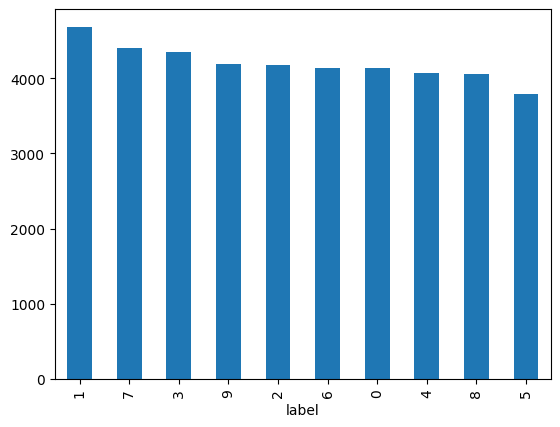

In [10]:
df_train["label"].value_counts().plot(kind= "bar")

In [11]:
pixel_data = df_train.drop(columns=["label"]).values
print("Shape:", pixel_data.shape)

Shape: (42000, 784)


In [12]:
pixel_data

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [13]:
print("Minimum pixel value:", pixel_data.min())
print("Maximum pixel value:", pixel_data.max())

Minimum pixel value: 0
Maximum pixel value: 255


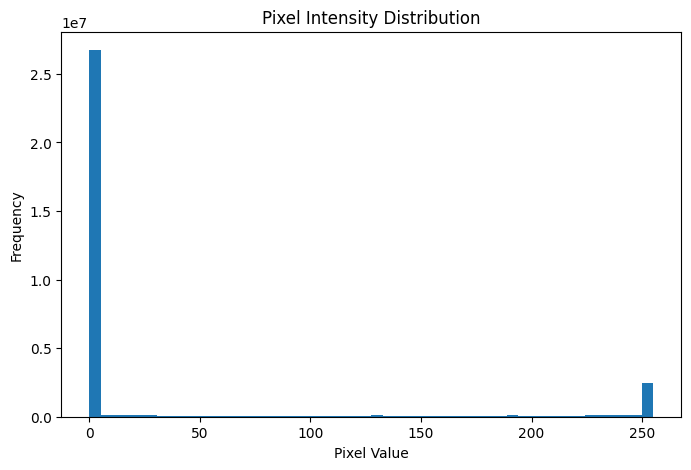

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
plt.hist(pixel_data.flatten(), bins=50)
plt.title("Pixel Intensity Distribution")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.show()

In [15]:
print("Mean pixel intensity:", pixel_data.mean())
print("Std pixel intensity:", pixel_data.std())

Mean pixel intensity: 33.408911169825075
Std pixel intensity: 78.677739760763


In [16]:
import numpy as np
blank_images = np.where(pixel_data.sum(axis=1) == 0)[0]
print("Number of completely blank images:", len(blank_images))

Number of completely blank images: 0


In [17]:
white_images = np.where(pixel_data.sum(axis=1) == 255*784)[0]
print("Number of completely white images:", len(white_images))

Number of completely white images: 0


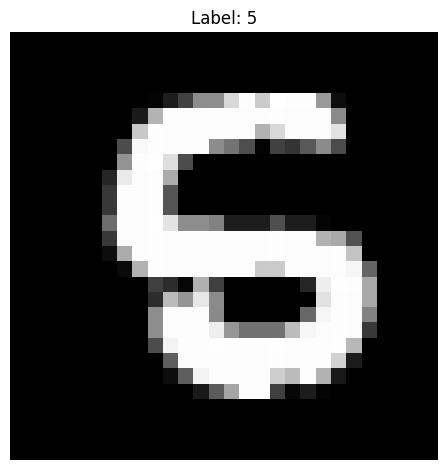

In [18]:
k=19
img = df_train.iloc[k, 1:].values.reshape(28,28)
plt.imshow(img, cmap="gray")
plt.axis("off")
plt.title(f"Label: {df_train["label"][k]}")

plt.tight_layout()
plt.show()


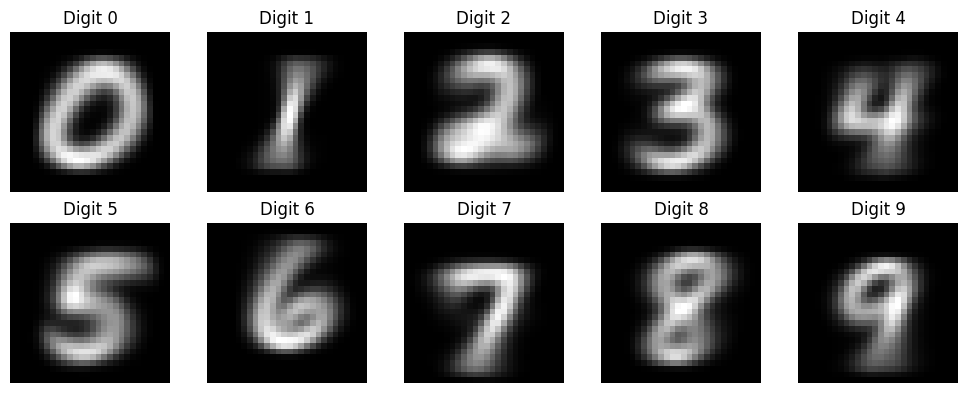

In [19]:
labels = df_train["label"].values

plt.figure(figsize=(10,4))
for digit in range(10):
  digit_pixels = pixel_data[labels == digit]
  mean_image = digit_pixels.mean(axis=0).reshape(28,28)

  plt.subplot(2,5,digit+1)
  plt.imshow(mean_image, cmap="gray")
  plt.title(f"Digit {digit}")
  plt.axis("off")

plt.tight_layout()
plt.show()

In [20]:
# Test pixel extraction
pixel_test = df_test.values.astype(np.float32)

print("Train mean:", pixel_data.mean())
print("Test mean:", pixel_test.mean())

print("Train std:", pixel_data.std())
print("Test std:", pixel_test.std())



Train mean: 33.408911169825075
Test mean: 33.35155
Train std: 78.677739760763
Test std: 78.61919


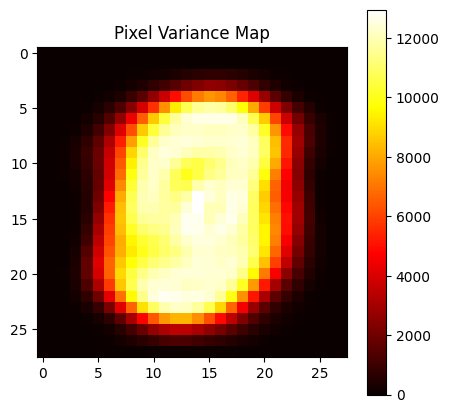

In [21]:
variance_map = pixel_data.var(axis=0).reshape(28,28)

plt.figure(figsize=(5,5))
plt.imshow(variance_map, cmap="hot")
plt.title("Pixel Variance Map")
plt.colorbar()
plt.show()

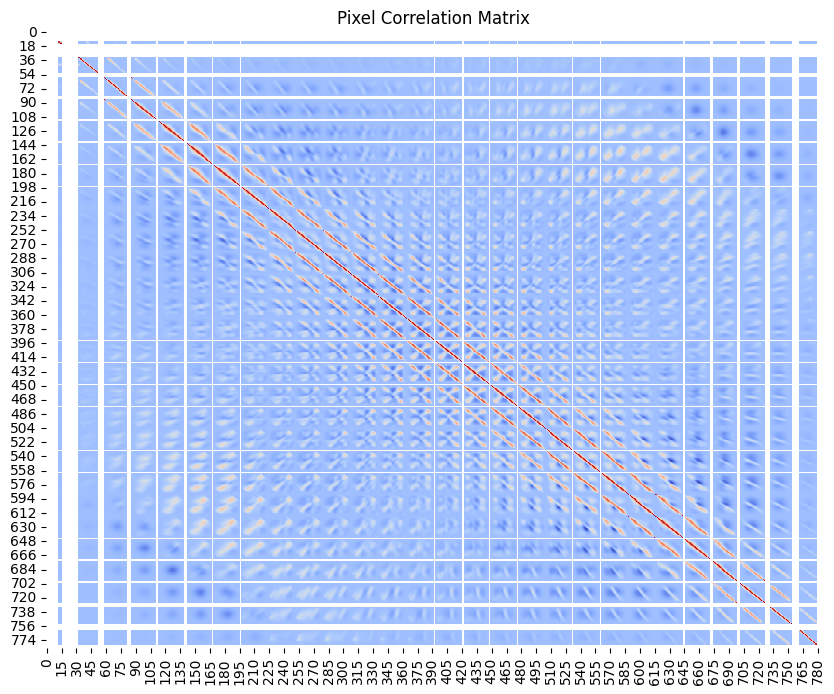

In [22]:
import seaborn as sns
pixel_df = pd.DataFrame(pixel_data)

corr_matrix = pixel_df.corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, cmap="coolwarm", cbar=False)
plt.title("Pixel Correlation Matrix")
plt.show()

In [23]:
image_means = pixel_data.mean(axis=1)

print("Mean intensity range:", image_means.min(), image_means.max())

Mean intensity range: 6.487244897959184 101.3813775510204


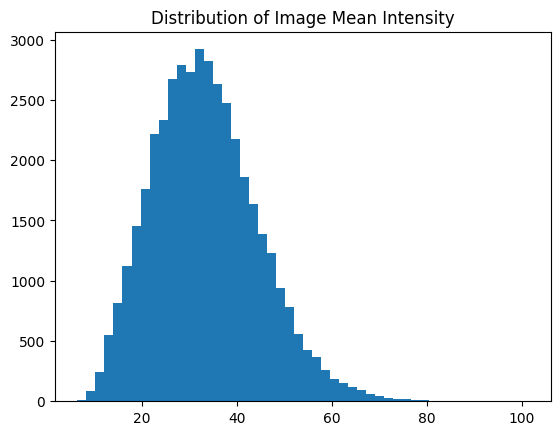

In [24]:
plt.hist(image_means, bins=50)
plt.title("Distribution of Image Mean Intensity")
plt.show()

In [25]:
Q1 = np.percentile(image_means, 25)
Q3 = np.percentile(image_means, 75)
IQR = Q3 - Q1

lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

outliers = np.where((image_means < lower) | (image_means > upper))[0]

print("Number of intensity outliers:", len(outliers))

Number of intensity outliers: 449


## Data Preprocessing

In [26]:
y = df_train["label"].values.astype(np.int64)
X = df_train.drop(columns="label").values.astype(np.int64)

In [27]:
y.dtype

dtype('int64')

In [28]:
X.dtype

dtype('int64')

### Normalize

In [29]:
X = X / 255.0
X_test = df_test.values.astype(np.int64) / 255.0

### Train/Validation split

In [30]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y
)

print(X_train.shape, X_val.shape)

(37800, 784) (4200, 784)


In [31]:
# Reshape for CNN (TF expects NHWC)
X_train = X_train.reshape(-1, 28, 28, 1)
X_val   = X_val.reshape(-1, 28, 28, 1)
X_test  = X_test.reshape(-1, 28, 28, 1)

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape)

(37800, 28, 28, 1) (37800,) (4200, 28, 28, 1) (4200,) (28000, 28, 28, 1)


### Build Dataloaders

In [32]:
import tensorflow as tf

BATCH_SIZE = 128

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_ds   = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_ds  = tf.data.Dataset.from_tensor_slices(X_test)

In [33]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = (
    train_ds
    .shuffle(buffer_size=len(X_train), reshuffle_each_iteration=True)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

val_ds = (
    val_ds
    .batch(256)
    .prefetch(AUTOTUNE)
)

test_ds = (
    test_ds
    .batch(256)
    .prefetch(AUTOTUNE)
)

In [34]:
xb, yb = next(iter(train_ds))
print("X batch:", xb.shape, xb.dtype)
print("y batch:", yb.shape, yb.dtype)
print("pixel range:", tf.reduce_min(xb).numpy(), tf.reduce_max(xb).numpy())

X batch: (128, 28, 28, 1) <dtype: 'float64'>
y batch: (128,) <dtype: 'int64'>
pixel range: 0.0 1.0


## Baseline Model

In [35]:
import tensorflow as tf

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [42]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 305,312 (1.16 MB)

 Trainable params: 101,770 (397.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 203,542 (795.09 KB)

In [36]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',   # because labels are integers 0–9
    metrics=['accuracy']
)

In [37]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5
)

Epoch 1/5
296/296 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7889 - loss: 0.7558 - val_accuracy: 0.9310 - val_loss: 0.2378
Epoch 2/5
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9382 - loss: 0.2119 - val_accuracy: 0.9507 - val_loss: 0.1741
Epoch 3/5
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9579 - loss: 0.1495 - val_accuracy: 0.9540 - val_loss: 0.1518
Epoch 4/5
296/296 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9676 - loss: 0.1129 - val_accuracy: 0.9619 - val_loss: 0.1251
Epoch 5/5
296/296 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9744 - loss: 0.0934 - val_accuracy: 0.9664 - val_loss: 0.1144


In [38]:
val_loss, val_acc = model.evaluate(val_ds)
print("Validation Accuracy:", val_acc)

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9684 - loss: 0.1107
Validation Accuracy: 0.9664285778999329


## Final CNN Model

In [43]:
import tensorflow as tf

cnn = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(28, 28, 1)),

    tf.keras.layers.Conv2D(32, (3,3), padding="same", activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (3,3), padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv2D(64, (3,3), padding="same", activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3,3), padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation="softmax"),
])

In [45]:
cnn.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 468,202 (1.79 MB)

 Trainable params: 468,010 (1.79 MB)

 Non-trainable params: 192 (768.00 B)

In [46]:
cnn.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

### Callbacks

In [47]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        "best_cnn.keras", monitor="val_accuracy", save_best_only=True, mode="max"
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy", patience=3, restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=2, min_lr=1e-5, verbose=1
    )
]

In [48]:
history = cnn.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    callbacks=callbacks
)

Epoch 1/15
296/296 ━━━━━━━━━━━━━━━━━━━━ 181s 593ms/step - accuracy: 0.6027 - loss: 1.3338 - val_accuracy: 0.8250 - val_loss: 0.9335 - learning_rate: 0.0010
Epoch 2/15
296/296 ━━━━━━━━━━━━━━━━━━━━ 176s 593ms/step - accuracy: 0.9235 - loss: 0.2468 - val_accuracy: 0.9745 - val_loss: 0.0931 - learning_rate: 0.0010
Epoch 3/15
296/296 ━━━━━━━━━━━━━━━━━━━━ 175s 591ms/step - accuracy: 0.9470 - loss: 0.1693 - val_accuracy: 0.9850 - val_loss: 0.0564 - learning_rate: 0.0010
Epoch 4/15
296/296 ━━━━━━━━━━━━━━━━━━━━ 173s 584ms/step - accuracy: 0.9561 - loss: 0.1379 - val_accuracy: 0.9886 - val_loss: 0.0496 - learning_rate: 0.0010
Epoch 5/15
296/296 ━━━━━━━━━━━━━━━━━━━━ 179s 605ms/step - accuracy: 0.9646 - loss: 0.1184 - val_accuracy: 0.9876 - val_loss: 0.0474 - learning_rate: 0.0010
Epoch 6/15
296/296 ━━━━━━━━━━━━━━━━━━━━ 176s 595ms/step - accuracy: 0.9707 - loss: 0.0966 - val_accuracy: 0.9900 - val_loss: 0.0423 - learning_rate: 0.0010
Epoch 7/15
296/296 ━━━━━━━━━━━━━━━━━━━━ 201s 591ms/step - accura

In [49]:
val_loss, val_acc = cnn.evaluate(val_ds)
print("Validation Accuracy:", val_acc)

17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 439ms/step - accuracy: 0.9902 - loss: 0.0387
Validation Accuracy: 0.9900000095367432


## Evaluation

In [50]:
import numpy as np

y_true = []
y_pred = []

for images, labels in val_ds:
    preds = cnn.predict(images, verbose=0)
    preds = np.argmax(preds, axis=1)

    y_true.extend(labels.numpy())
    y_pred.extend(preds)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

print("Prediction shape:", y_pred.shape)

Prediction shape: (4200,)


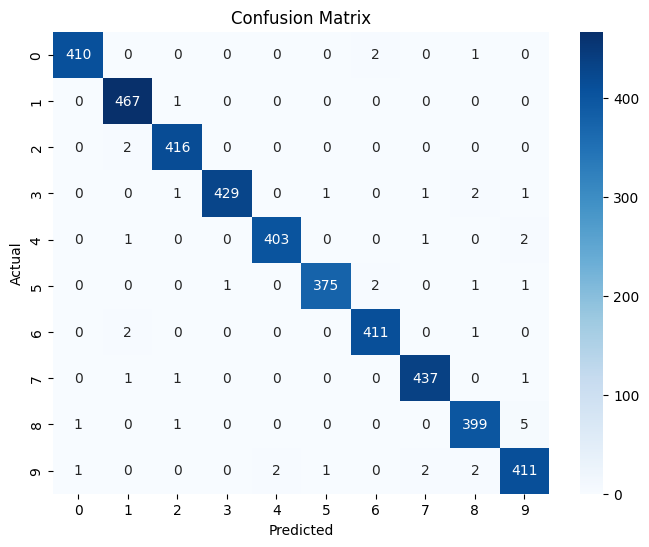

In [51]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [52]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       413
           1       0.99      1.00      0.99       468
           2       0.99      1.00      0.99       418
           3       1.00      0.99      0.99       435
           4       1.00      0.99      0.99       407
           5       0.99      0.99      0.99       380
           6       0.99      0.99      0.99       414
           7       0.99      0.99      0.99       440
           8       0.98      0.98      0.98       406
           9       0.98      0.98      0.98       419

    accuracy                           0.99      4200
   macro avg       0.99      0.99      0.99      4200
weighted avg       0.99      0.99      0.99      4200



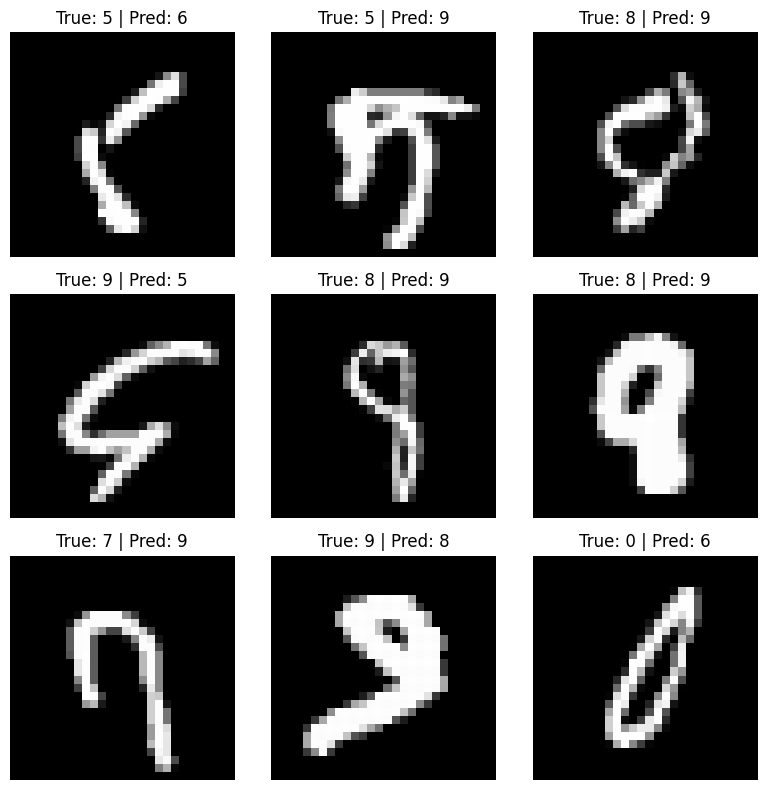

In [53]:
misclassified = np.where(y_true != y_pred)[0]

plt.figure(figsize=(8,8))
for i, idx in enumerate(misclassified[:9]):
    image = list(val_ds.unbatch().as_numpy_iterator())[idx][0]

    plt.subplot(3,3,i+1)
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title(f"True: {y_true[idx]} | Pred: {y_pred[idx]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

The model primarily struggles with visually ambiguous digits like 4 and 9. Most errors occur when the digit shape deviates from the canonical structure.